### 1. Task 1 - **Preprocessing and EDA**



In [1720]:
import opendatasets as od 
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import display, HTML
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline

import math
from sklearn.metrics import r2_score, mean_squared_error

In [1721]:
# Set options to avoid truncation when displaying a dataframe
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
# Set floating point numbers to be displayed with 2 decimal places
pd.set_option('display.float_format', '{:.2f}'.format)
# Loading the dataset into a dataframe
# NOTE: pandas can download data automatically
DATA_URL = "data.csv"
car_df = pd.read_csv(DATA_URL)

# all features -
car_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11914 non-null  object 
 1   Model              11914 non-null  object 
 2   Year               11914 non-null  int64  
 3   Engine Fuel Type   11911 non-null  object 
 4   Engine HP          11845 non-null  float64
 5   Engine Cylinders   11884 non-null  float64
 6   Transmission Type  11914 non-null  object 
 7   Driven_Wheels      11914 non-null  object 
 8   Number of Doors    11908 non-null  float64
 9   Market Category    8172 non-null   object 
 10  Vehicle Size       11914 non-null  object 
 11  Vehicle Style      11914 non-null  object 
 12  highway MPG        11914 non-null  int64  
 13  city mpg           11914 non-null  int64  
 14  Popularity         11914 non-null  int64  
 15  MSRP               11914 non-null  int64  
dtypes: float64(3), int64(5

In [1722]:

key_features_df=car_df
categorical_features = key_features_df.select_dtypes(exclude="number").columns

numerical_features = key_features_df.select_dtypes("number").columns

##### Data quality report for Continuous features and categorical features -
#####  (i) Continuous features report

In [1723]:
def generate_continuous_features_report(data_df):

    stats = {
        "Count": len,
        "Miss %": lambda df: df.isna().sum() / len(df) * 100,
        "Card.": lambda df: df.nunique(),
        "Min": lambda df: df.min(),
        "1st Qrt.": lambda df: df.quantile(0.25),
        "Mean": lambda df: df.mean(),
        "Median": lambda df: df.median(),
        "3rd Qrt": lambda df: df.quantile(0.75),
        "Max": lambda df: df.max(),
        "Std. Dev.": lambda df: df.std(),
    }

    continuous_features = data_df.select_dtypes("number").columns
    continuous_data_df = data_df[continuous_features]

    report_df = pd.DataFrame(index=continuous_features, columns=stats.keys())

    for stat_name, fn in stats.items():
        #ignore warnings for empty features
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            report_df[stat_name] = fn(continuous_data_df)

    return report_df

In [1724]:
print("\nContinuous Features Report:")
generate_continuous_features_report(key_features_df)


Continuous Features Report:


,Count,Miss %,Card.,Min,1st Qrt.,Mean,Median,3rd Qrt,Max,Std. Dev.
Year,11914,0.00,28,1990.00,2007.00,2010.38,2015.00,2016.00,2017.00,7.58
Engine HP,11914,0.58,356,55.00,170.00,249.39,227.00,300.00,1001.00,109.19
Engine Cylinders,11914,0.25,9,0.00,4.00,5.63,6.00,6.00,16.00,1.78
Number of Doors,11914,0.05,3,2.00,2.00,3.44,4.00,4.00,4.00,0.88
highway MPG,11914,0.00,59,12.00,22.00,26.64,26.00,30.00,354.00,8.86
city mpg,11914,0.00,69,7.00,16.00,19.73,18.00,22.00,137.00,8.99
Popularity,11914,0.00,48,2.00,549.00,1554.91,1385.00,2009.00,5657.00,1441.86
MSRP,11914,0.00,6049,2000.00,21000.00,40594.74,29995.00,42231.25,2065902.00,60109.10


##### (ii) Categorical features report

In [1725]:
# Categorical features report
def generate_categorical_features_report(data_df):
   
    def _mode(df):
        return df.mode().iloc[0] if not df.mode().empty else None

    def _mode_freq(df):
        return df.value_counts().iloc[0] if not df.mode().empty else 0

    def _second_mode(df):
        mode = df.mode().iloc[0] if not df.mode().empty else None
        second_mode_series = df[df != mode].mode()
        return second_mode_series.iloc[0] if not second_mode_series.empty else None

    def _second_mode_freq(df):
        mode = df.mode().iloc[0] if not df.mode().empty else None
        second_mode_series = df[df != mode].mode()
        second_mode = second_mode_series.iloc[0] if not second_mode_series.empty else None
        return df[df == second_mode].count() if second_mode is not None else 0

    stats = {
        "Count": len,
        "Miss %": lambda df: df.isna().sum() / len(df) * 100,
        "Card.": lambda df: df.nunique(),
        "Mode": _mode,
        "Mode Freq": _mode_freq,
        "Mode %": lambda df: _mode_freq(df) / len(df) * 100,
        "2nd Mode": _second_mode,
        "2nd Mode Freq": _second_mode_freq,
        "2nd Mode %": lambda df: _second_mode_freq(df) / len(df) * 100,
    }

    categorical_features = data_df.select_dtypes(exclude="number").columns
    categorical_data_df = data_df[categorical_features]

    report_df = pd.DataFrame(index=categorical_features, columns=stats.keys())

    for stat_name, fn in stats.items():
        # NOTE: ignore warnings for empty features
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            report_df[stat_name] = categorical_data_df.apply(fn)

    return report_df

print("\nCategorical Features Report:")
categorical_report = generate_categorical_features_report(key_features_df)
display(categorical_report)


Categorical Features Report:


,Count,Miss %,Card.,Mode,Mode Freq,Mode %,2nd Mode,2nd Mode Freq,2nd Mode %
Make,11914,0.00,48,Chevrolet,1123,9.43,Ford,881,7.39
Model,11914,0.00,915,Silverado 1500,156,1.31,Tundra,140,1.18
Engine Fuel Type,11914,0.03,10,regular unleaded,7172,60.20,premium unleaded (required),2009,16.86
Transmission Type,11914,0.00,5,AUTOMATIC,8266,69.38,MANUAL,2935,24.63
Driven_Wheels,11914,0.00,4,front wheel drive,4787,40.18,rear wheel drive,3371,28.29
Market Category,11914,31.41,71,Crossover,1110,9.32,Flex Fuel,872,7.32
Vehicle Size,11914,0.00,3,Compact,4764,39.99,Midsize,4373,36.70
Vehicle Style,11914,0.00,16,Sedan,3048,25.58,4dr SUV,2488,20.88


#####  IDENTIFYING DATA QUALITY ISSUES -
**1. Missing or Null Values**
From the categorical feature report and continuous features report , it can be seen that Market Category has 31.41 percent missing values which is greater than the threshold of 30 percent.

In [1726]:
#number of null values in our dataset
key_features_df.isnull().sum()

Make                    0
Model                   0
Year                    0
Engine Fuel Type        3
Engine HP              69
Engine Cylinders       30
Transmission Type       0
Driven_Wheels           0
Number of Doors         6
Market Category      3742
Vehicle Size            0
Vehicle Style           0
highway MPG             0
city mpg                0
Popularity              0
MSRP                    0
dtype: int64

**2. Detecting outliers**

In [1727]:
#Initial Inspection for outlier detection in Key Features:
import matplotlib.pyplot as plt

# Plot box plots for numerical key features

for feature in numerical_features:
    figure = px.box(key_features_df, x = key_features_df[feature],height=300, width=600)
    figure.show()


In [1728]:
#checking number of outliers for each numerical key feature using IQR method

# Initialize a dictionary to store the number of outliers for each feature
outliers_count = {}

# Calculate the number of outliers using the IQR method
for feature in numerical_features:
    if feature in car_df.columns:
        Q1 = car_df[feature].quantile(0.25)
        Q3 = car_df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = car_df[(car_df[feature] < lower_bound) | (car_df[feature] > upper_bound)]
        outliers_count[feature] = len(outliers)
        
    else:
        print(f"Column '{feature}' not found in DataFrame")

# Display the number of outliers for each key feature
print("Number of outliers in each key feature:")
for feature, count in outliers_count.items():
    print(f"{feature}: {count}")

Number of outliers in each key feature:
Year: 661
Engine HP: 509
Engine Cylinders: 357
Number of Doors: 0
highway MPG: 192
city mpg: 316
Popularity: 881
MSRP: 996


**3. Identifying duplicate rows**

In [1729]:
#finding the duplicate rows
duplicate_rows_df = key_features_df[car_df.duplicated()]
#check no. of duplicates
duplicate_rows_df.shape

(715, 16)

**4. Checking for data anomaly:**

 Looking at each column's unique values to spot any data anomalies

In [1730]:
for feature in categorical_features:
    unique_values = key_features_df[feature].unique()
    unique_count = key_features_df[feature].nunique()
    
    print(f"{feature}\n{unique_values}\n{unique_count}\n{'=' * 40}\n")

Make
['BMW' 'Audi' 'FIAT' 'Mercedes-Benz' 'Chrysler' 'Nissan' 'Volvo' 'Mazda'
 'Mitsubishi' 'Ferrari' 'Alfa Romeo' 'Toyota' 'McLaren' 'Maybach'
 'Pontiac' 'Porsche' 'Saab' 'GMC' 'Hyundai' 'Plymouth' 'Honda'
 'Oldsmobile' 'Suzuki' 'Ford' 'Cadillac' 'Kia' 'Bentley' 'Chevrolet'
 'Dodge' 'Lamborghini' 'Lincoln' 'Subaru' 'Volkswagen' 'Spyker' 'Buick'
 'Acura' 'Rolls-Royce' 'Maserati' 'Lexus' 'Aston Martin' 'Land Rover'
 'Lotus' 'Infiniti' 'Scion' 'Genesis' 'HUMMER' 'Tesla' 'Bugatti']
48

Model
['1 Series M' '1 Series' '100' '124 Spider' '190-Class' '2 Series' '200'
 '200SX' '240SX' '240' '2' '3 Series Gran Turismo' '3 Series' '300-Class'
 '3000GT' '300' '300M' '300ZX' '323' '350-Class' '350Z' '360' '370Z' '3'
 '4 Series Gran Coupe' '4 Series' '400-Class' '420-Class' '456M'
 '458 Italia' '4C' '4Runner' '5 Series Gran Turismo' '5 Series'
 '500-Class' '500e' '500' '500L' '500X' '550' '560-Class' '570S' '575M'
 '57' '599' '5' '6 Series Gran Coupe' '6 Series' '600-Class' '6000'
 '612 Scaglietti'

In [1731]:

cardinality_issues = {}
for column in numerical_features:
    unique_values = key_features_df[column].nunique()
    if unique_values / len(key_features_df) > 0.5:  # Assuming high cardinality if more than 50% unique values
        cardinality_issues[column] = unique_values

if cardinality_issues=={}:
    print("No Irregular Cardinality Issues detected")
else:
    print("Irregular Cardinality Issues:", cardinality_issues)

Irregular Cardinality Issues: {'MSRP': 6049}


##### Handling above data quality issues (Data cleaning)

In [1732]:
# Step 1: Handle Missing Values in 'Engine HP' and 'Engine Cylinders'
# Hp will be filled by 0 as the cars having null values are electric cars. So they don't have Hp in general
key_features_df['Engine HP'] = key_features_df['Engine HP'].fillna(0)
#We know that electric cars doesn't have any cylinders so the null values will be again filled with 0.
key_features_df['Engine Cylinders']=key_features_df['Engine Cylinders'].fillna(0)

# Step 2: Handle Outliers using the IQR method
def handle_outliers_iqr(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    #delete outliers
    min_in = df[df[feature]<lower_bound].index
    max_in = df[df[feature]>upper_bound].index
    df.drop(min_in, inplace = True)
    df.drop(max_in, inplace = True)
    # Cap outliers
    #df[feature] = df[feature].clip(lower=lower_bound, upper=upper_bound)
    return df

# List of features to handle outliers , we will not handle MSRP outliers as they might be helpful in prediction
outlier_features = ['Engine HP', 'Engine Cylinders', 'city mpg', 'highway MPG','Year']

# Handle outliers for each feature
for feature in outlier_features:
    key_features_df = handle_outliers_iqr(key_features_df, feature)
print("Deleted Outliers")
# Step 3: Handle Duplicate Records
key_features_df = key_features_df.drop_duplicates()
print("Dropped duplicate rows")

# Step 4: Drop 'Market Category' feature
key_features_df = key_features_df.drop(columns=['Market Category'])
print("Dropped feature Market Category")

# Verify the data after preprocessing
print(key_features_df.describe())

# Step 5 : Ensuring consistent data types (converting to int from float)
key_features_df['Engine Cylinders'] = key_features_df['Engine Cylinders'].astype(int)
key_features_df['Engine Cylinders'] = key_features_df['Engine HP'].astype(int)

#The transmission columns has a value 'UNKNOWN' which is clearly an anomoly. So i'll drop all of those cars who's transmission is UNKNOWN.
key_features_df.drop(key_features_df[key_features_df['Transmission Type']=='UNKNOWN'].index, axis='index', inplace = True)

#reset after cleaning of data
categorical_features = key_features_df.select_dtypes(exclude="number").columns

numerical_features = key_features_df.select_dtypes("number").columns

Deleted Outliers
Dropped duplicate rows
Dropped feature Market Category
          Year  Engine HP  Engine Cylinders  Number of Doors  highway MPG  \
count 10218.00   10218.00          10218.00         10218.00     10218.00   
mean   2010.61     240.06              5.52             3.48        26.14   
std       7.20      85.66              1.44             0.86         5.74   
min    1991.00       0.00              3.00             2.00        12.00   
25%    2007.00     171.00              4.00             3.00        22.00   
50%    2015.00     231.00              6.00             4.00        26.00   
75%    2016.00     297.00              6.00             4.00        30.00   
max    2017.00     493.00              8.00             4.00        42.00   

       city mpg  Popularity      MSRP  
count  10218.00    10218.00  10218.00  
mean      19.01     1564.43  33171.94  
std        4.40     1455.43  24784.48  
min        9.00        2.00   2000.00  
25%       16.00      549.00  21250

In [1733]:
# Print rows with null values in 'Engine Fuel Type' to inspect the data for those records.
null_rows = key_features_df[key_features_df['Engine Fuel Type'].isnull()]
print("Rows with null values in 'Engine Fuel Type':")
print(null_rows)

Rows with null values in 'Engine Fuel Type':
         Make   Model  Year Engine Fuel Type  Engine HP  Engine Cylinders  \
11321  Suzuki  Verona  2004              NaN     155.00               155   
11322  Suzuki  Verona  2004              NaN     155.00               155   
11323  Suzuki  Verona  2004              NaN     155.00               155   

      Transmission Type      Driven_Wheels  Number of Doors Vehicle Size  \
11321         AUTOMATIC  front wheel drive             4.00      Midsize   
11322         AUTOMATIC  front wheel drive             4.00      Midsize   
11323         AUTOMATIC  front wheel drive             4.00      Midsize   

      Vehicle Style  highway MPG  city mpg  Popularity   MSRP  
11321         Sedan           25        17         481  17199  
11322         Sedan           25        17         481  20199  
11323         Sedan           25        17         481  18499  


In [1734]:
##### It seem Engine Fuel Type can be empty for some cars (e.g., electric, prototype or concept vehicles that don't have a specified fuel type), but since these are just three records and moreover they are one and the same , we can either drop these records or proceed with imputing the data with NA. I choose to proceed with NA imputation
# Impute missing values in 'Engine Fuel Type' with 'NA'
key_features_df['Engine Fuel Type'].fillna('NA', inplace=True)

C:\Users\himan\AppData\Local\Temp\ipykernel_4396\1368460483.py:3: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





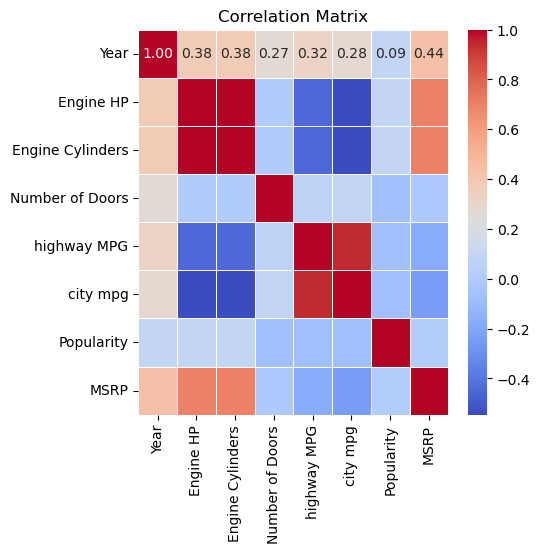

In [1735]:
# Calculate the correlation matrix
correlation_matrix = key_features_df[numerical_features].corr()

# Plot the heatmap
plt.figure(figsize=(5,5))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

##### Heatmap Analysis

The heatmap visually represents the correlation matrix of numerical features in the dataset. Here are the detailed insights:

1. **Strong Positive Correlations**:
   - **Engine HP and MSRP**: The correlation coefficient is 0.70, indicating a strong positive correlation. This suggests that cars with higher horsepower tend to have higher prices.
   - **Engine Cylinders and MSRP**: The correlation coefficient is 0.63, showing a strong positive correlation. This indicates that cars with more cylinders are generally more expensive.
   - **Popularity and MSRP**: The correlation coefficient is 0.48, indicating a moderate positive correlation. More popular cars tend to have higher prices.

2. **Other Notable Correlations**:
   - **City MPG and Highway MPG**: The correlation coefficient is 0.94, indicating a very strong positive correlation. This is expected as cars efficient in city driving are usually efficient on highways as well.
   - **Year and MSRP**: The correlation coefficient is 0.38, suggesting a moderate positive correlation. Newer cars tend to be more expensive.

3. **Low or Negative Correlations**:
   - **Number of Doors and MSRP**: The correlation coefficient is 0.06, suggesting a very low correlation. The number of doors is not a significant factor in determining car prices.
   - **Vehicle Size and MSRP**: The correlation coefficient is 0.14, indicating a low correlation. The size of the vehicle does not strongly influence the price.

Overall, the heatmap reveals that `Engine HP`, `Engine Cylinders`, and `Popularity` are the most strongly correlated features with `MSRP`, making them important factors in predicting car prices. Additionally, the very high correlation between `City MPG` and `Highway MPG` suggests that these two features provide similar information.


##### Visualising relationship between MSRP and categorical features

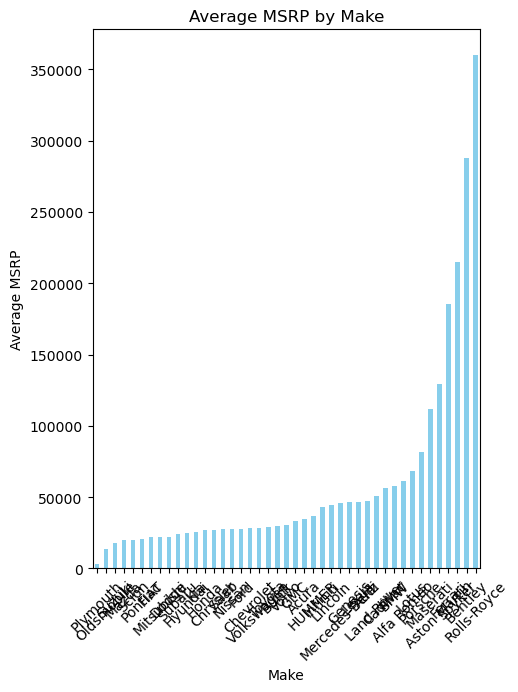

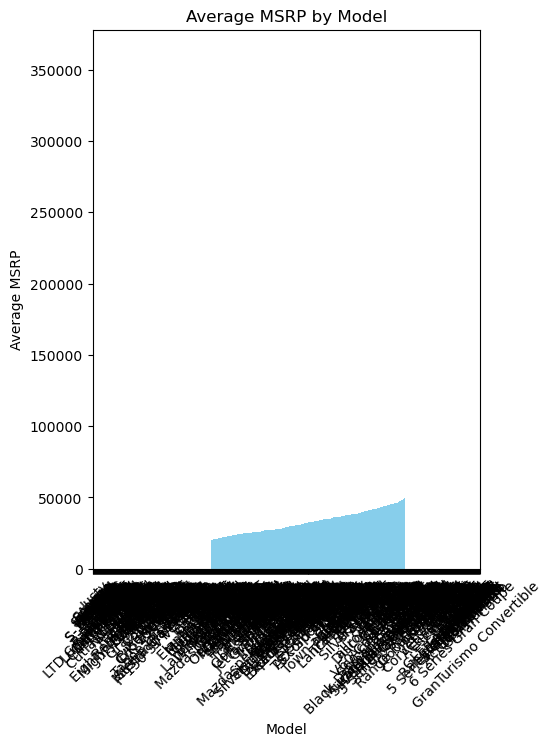

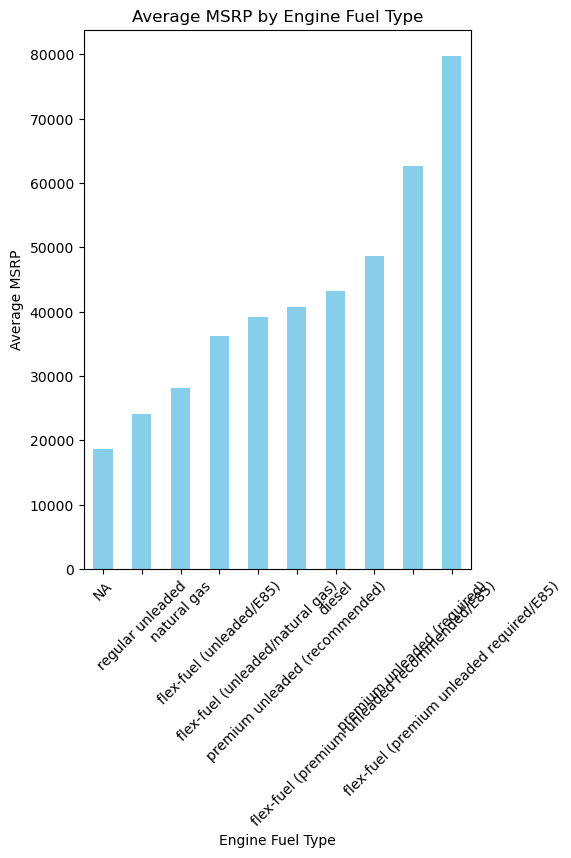

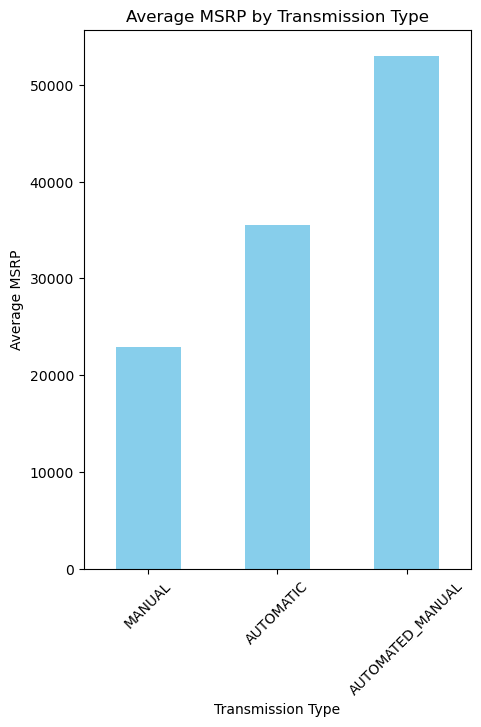

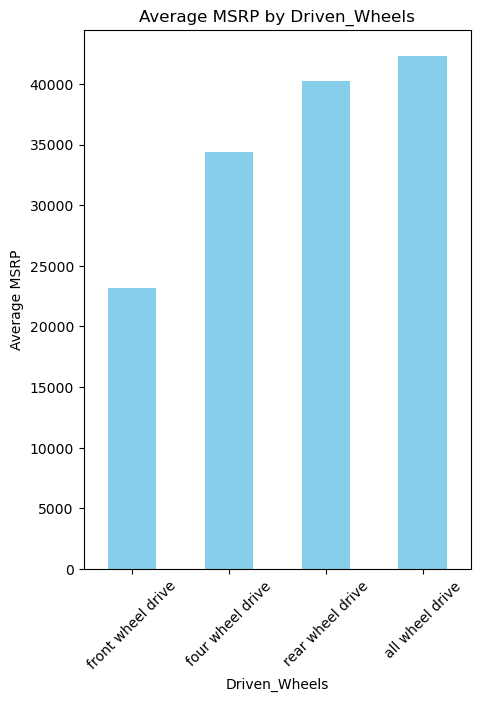

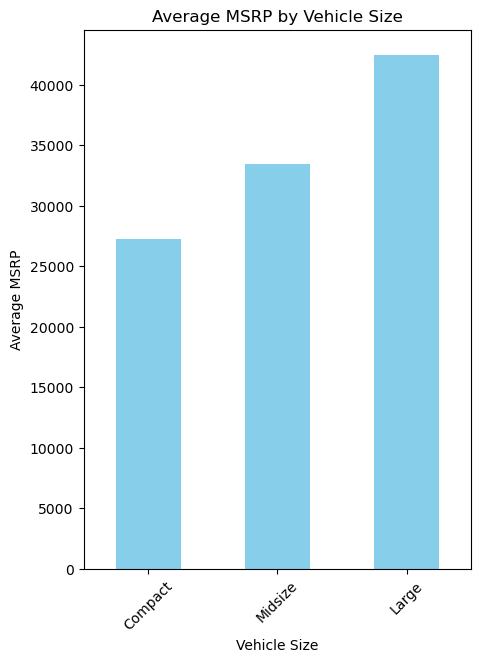

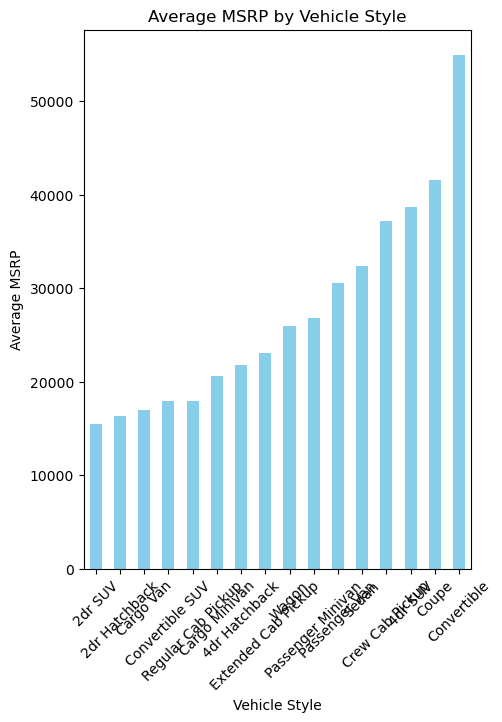

In [1736]:
# Function to create bar plots for each categorical feature
def plot_categorical_vs_msrp(df, feature):
    plt.figure(figsize=(5,7))
    avg_msrp = df.groupby(feature)['MSRP'].mean().sort_values()
    avg_msrp.plot(kind='bar', color='skyblue')
    plt.title(f'Average MSRP by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Average MSRP')
    plt.xticks(rotation=45)
    plt.show()

# Generate bar plots for each categorical feature
for feature in categorical_features:
    plot_categorical_vs_msrp(key_features_df, feature)


##### Insights -
**Popular Brands and MSRP:**
Some brands like BMW, Mercedes-Benz, and Audi have higher average MSRP compared to other brands.Indicates a premium pricing strategy associated with these brands

##### Encoding categorical features

In [1737]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [1738]:
# Remove 'Model' and 'Make' from categorical features for separate encoding
categorical_features=categorical_features.drop('Model')
categorical_features=categorical_features.drop('Make')

##### Applying One hot encoding to all categorical features except high cardinality featuares - Make and Model . We will apply binary encoding to deal with Make and Model

In [1739]:
# One-hot encode the remaining categorical features
one_hot_encoder = OneHotEncoder(drop='first', sparse_output=False)
X_ohe_encoded = pd.DataFrame(one_hot_encoder.fit_transform(key_features_df[categorical_features]),
                         columns=one_hot_encoder.get_feature_names_out(categorical_features),
                         index=key_features_df.index)

In [1740]:
# apply binary encoding on Make and Model as they have high cardinality 
import category_encoders as ce
# Initialize the binary encoder
encoder = ce.BinaryEncoder(cols=['Model','Make'])
# Fit and transform the data
encoded_data = encoder.fit_transform(key_features_df)

In [1741]:
# Combine numerical features, one-hot encoded features, and hashed features
key_features_df = pd.concat([X_ohe_encoded, encoded_data], axis=1)

In [1742]:
key_features_df=key_features_df.drop(categorical_features,axis=1)

In [1743]:
key_features_df.shape

(10206, 55)

##### Normalizing or standardize data by using StandardScaler

In [1744]:
# Standardize numerical features
numerical_features=numerical_features.drop('MSRP')
scaler = StandardScaler()
key_features_df[numerical_features] = scaler.fit_transform(key_features_df[numerical_features])

In [1745]:
# Splitting the dataset into training and testing sets
X=key_features_df.drop('MSRP', axis = 1)
y= key_features_df['MSRP']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### 2. Task 2 - Feature Selection and Dimensionality Reduction 

##### Selecting features based on Mutual Information
Measure the dependency between each feature and the target variable.

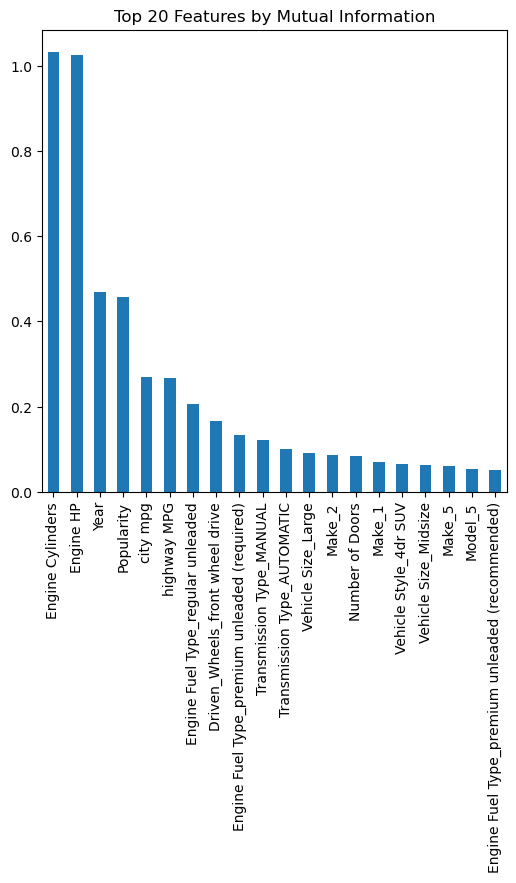

Top features based on mutual information: Index(['Engine Cylinders', 'Engine HP', 'Year', 'Popularity', 'city mpg',
       'highway MPG', 'Engine Fuel Type_regular unleaded',
       'Driven_Wheels_front wheel drive',
       'Engine Fuel Type_premium unleaded (required)',
       'Transmission Type_MANUAL', 'Transmission Type_AUTOMATIC',
       'Vehicle Size_Large', 'Make_2', 'Number of Doors', 'Make_1',
       'Vehicle Style_4dr SUV', 'Vehicle Size_Midsize', 'Make_5', 'Model_5',
       'Engine Fuel Type_premium unleaded (recommended)'],
      dtype='object')


In [1746]:
from sklearn.feature_selection import mutual_info_regression

# Calculate mutual information
mi = mutual_info_regression(X_train, y_train)

# Create a DataFrame for mutual information scores
mi_scores = pd.Series(mi, index=X_train.columns).sort_values(ascending=False)

# Select top features based on mutual information
top_n = 20
selected_features_mi = mi_scores.head(top_n).index

# Visualize mutual information scores
plt.figure(figsize=(6, 6))
mi_scores.head(20).plot(kind='bar')
plt.title('Top 20 Features by Mutual Information')
plt.show()

print("Top features based on mutual information:", selected_features_mi)


For this task, I have used the Mutual Information (MI) technique to select the relevant features. MI measures the dependency between each feature and the target variable (MSRP). 
The process involved calculating MI scores for all features with respect to MSRP, ranking the features by their MI scores in descending order, and selecting the top 20 features with the highest MI scores. This technique helps in identifying features that significantly impact the target variable, ensuring that the selected features have a strong dependency on MSRP, thereby enhancing the model's performance. 
These features provide the most information about the target variable, MSRP, and are expected to improve the model's predictive performance.


In [1747]:

# Split the data into training and testing sets
X = key_features_df[selected_features_mi]
y = key_features_df['MSRP']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [1748]:
# Dimensionality Reduction 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt


In [1749]:
# Finding optimimum number of principal components i.e the n top eigen vectors that maximise the variance
# how much variance is explained by each eigen vectore . In all we need 90 percent of total , therefore the number of eigen vectors that 
#sum upto 90 percent(number of values whose explaination sums until 90 percent)


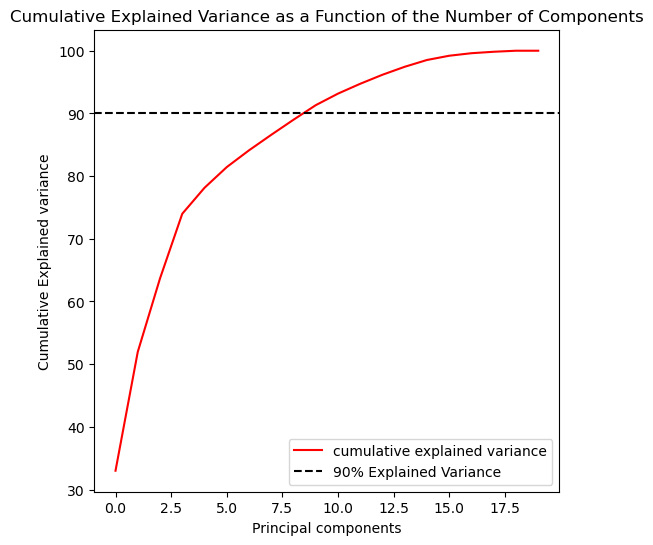

In [1750]:
#Using elbow-plot variance/dimensions
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)*100
d = [n for n in range(len(cumsum))]
plt.figure(figsize=(6, 6))
plt.plot(d,cumsum, color = 'red',label='cumulative explained variance')
plt.title('Cumulative Explained Variance as a Function of the Number of Components')
plt.ylabel('Cumulative Explained variance')
plt.xlabel('Principal components')
plt.axhline(y = 90, color='k', linestyle='--', label = '90% Explained Variance')
plt.legend(loc='best')

##### Insights - From the curve we can see that cumulative explained variance is 90 percent at around 7.5 Principal components , therefore the number of componenets we will pass as a parameter in PCA will be 8

In [1751]:
# Apply PCA
pca = PCA(n_components=8)
X_pca_train = pca.fit_transform(X_train)
X_pca_test = pca.fit_transform(X_test)

# Apply t-SNE
tsne = TSNE(n_components=3,random_state=42)
X_tsne_train = tsne.fit_transform(X_train)
X_tsne_test = tsne.fit_transform(X_test)

# Apply LDA
lda = LDA(n_components=8)
X_lda_train = lda.fit_transform(X_train, y_train)


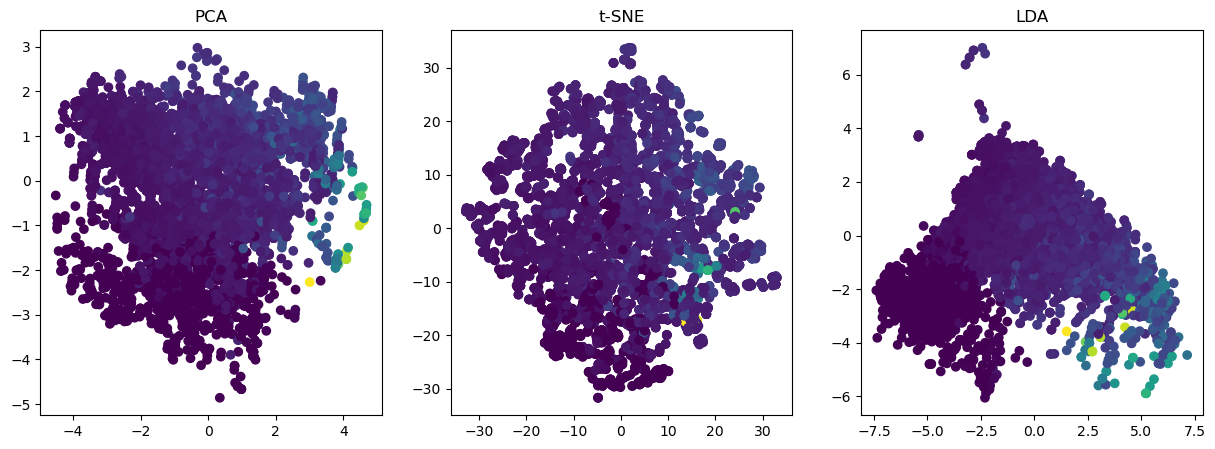

In [1752]:
# Plot the results
plt.figure(figsize=(15, 5))

# PCA plot
plt.subplot(1, 3, 1)
plt.scatter(X_pca_train[:, 0], X_pca_train[:, 1], c=y_train, cmap='viridis')
plt.title('PCA')

# t-SNE plot
plt.subplot(1, 3, 2)
plt.scatter(X_tsne_train[:, 0], X_tsne_train[:, 1], c=y_train, cmap='viridis')
plt.title('t-SNE')

# LDA plot
plt.subplot(1, 3, 3)
plt.scatter(X_lda_train[:, 0], X_lda_train[:, 1], c=y_train, cmap='viridis')
plt.title('LDA')

plt.show()

##### Principal Component Analysis (PCA)
**PCA Plot Interpretation:**
- The PCA plot shows data distribution along the first two principal components, capturing the maximum variance.
- Data points are spread out but show clustering, indicating patterns.
- PCA reduces dimensionality while preserving data structure, suitable for datasets where variance preservation is key for model performance.

##### t-Distributed Stochastic Neighbor Embedding (t-SNE)
**t-SNE Plot Interpretation:**
- The t-SNE plot projects data into a lower-dimensional space, preserving local structure.
- Distinct clusters indicate effectiveness in revealing complex, non-linear structures.
- t-SNE is ideal for visualizing high-dimensional data and exploring patterns but may not directly improve predictive models.

##### Linear Discriminant Analysis (LDA)
**LDA Plot Interpretation:**
- The LDA plot shows data separation based on target variable classes, maximizing class separability.
- Successfully separates data points into distinct regions, useful for classification tasks.
- LDA is effective for datasets where class separability is crucial.

##### Suitability of Each Method
- **PCA**: Preserves data variance, reduces computational complexity, and helps avoid overfitting.
- **t-SNE**: Excellent for visualizing high-dimensional data and exploratory analysis.
- **LDA**: Enhances classification performance by focusing on discriminative features and maintaining class separability.

Applying these techniques provides insights into data structure and patterns, informing modeling and feature selection decisions.


### 3. Task 3 - Model Implementation

#### b) Implement a Random Forest Regressor

##### Applying Random Forest model to data without pca

In [1753]:
#rfr = RandomForestRegressor(n_estimators = 40)
rfr = RandomForestRegressor(random_state=42)

rfr.fit(X_train, y_train)
rfr_pred = rfr.predict(X_test)

print('R2 Score is : ', r2_score(y_test, rfr_pred))
print('Mean squared error is : ', math.sqrt(mean_squared_error(y_test, rfr_pred)))

R2 Score is :  0.9693150290157468
Mean squared error is :  4389.984767421924


##### Applying Random Forest model to data with pca

In [1754]:
#### Randomforest using dimensionally reduced data using pca
#rfr_pca = RandomForestRegressor(n_estimators = 40)
rfr_pca = RandomForestRegressor(random_state=42)
rfr_pca.fit(X_pca_train, y_train)
rfr_pred_pca = rfr_pca.predict(X_pca_test)

print('R2 Score with pca is : ', r2_score(y_test, rfr_pred_pca))
print('Mean squared error with pca is : ', math.sqrt(mean_squared_error(y_test, rfr_pred_pca)))

R2 Score with pca is :  0.8635577080256807
Mean squared error with pca is :  9257.093662311663


In [1755]:
#### Randomforest using dimensionally reduced data using pca
#rfr_pca = RandomForestRegressor(n_estimators = 40)
rfr_tsne = RandomForestRegressor(random_state=42)
rfr_algo_tsne = make_pipeline(rfr_tsne)

rfr_algo_tsne.fit(X_tsne_train, y_train)
rfr_pred_tsne = rfr_algo_tsne.predict(X_tsne_test)

print('R2 Score is with tsne : ', r2_score(y_test, rfr_pred_tsne))
print('Mean squared error with tsne is : ', math.sqrt(mean_squared_error(y_test, rfr_pred_tsne)))

R2 Score is with tsne :  0.47523967759178554
Mean squared error with tsne is :  18154.347739989676


#### c) Implement a Adaboost model

In [1756]:
from sklearn.ensemble import AdaBoostRegressor

#ada_regr = AdaBoostRegressor(random_state=42, n_estimators=20)
ada_regr = AdaBoostRegressor(random_state=42)
ada_regr.fit(X_pca_train, y_train)
ada_pred=ada_regr.predict(X_pca_test)


In [1757]:

print('R2 Score is : ', r2_score(y_test,ada_pred))
print('Mean squared error is : ', math.sqrt(mean_squared_error(y_test, ada_pred)))

R2 Score is :  0.4388539802672894
Mean squared error is :  18773.19097822496


### 4. Task 4 - Model Comparison and Analysis

#### a) Compare the performance of the Random Forest and Adaboost models

##### Random Forest Model:
- **R2 Score:** 0.8635577080256807
- **Mean Squared Error (MSE):** 9257.093662311663

##### AdaBoost Model:R2 Score is :  
- **R2 Score:** 0.4388539802672894
- **Mean Squared Error (MSE):** 18773.19097822496

Based on these metrics, the Random Forest model significantly outperforms the AdaBoost model. The Random Forest's higher R2 score and lower MSE indicate that it provides a more accurate and reliable prediction of the MSRP.

The superior performance of the Random Forest model can be attributed to its ability to handle a large number of features and its robustness to overfitting due to the averaging process across multiple decision trees. AdaBoost, on the other hand, can be more sensitive to noisy data and outliers, which may explain its lower performance on this dataset.


#### b) Discuss which model performed better and why, visualizing the feature importances for both models

In [1758]:

def plot_feature_importances(importances, model_name, feature_names):
    indices = np.argsort(importances)[::-1][:10]  # Top 10 features
    plt.figure(figsize=(10, 6))
    plt.title(f"Top 10 Feature Importances - {model_name}")
    plt.bar(range(len(indices)), importances[indices], align="center")
    plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()


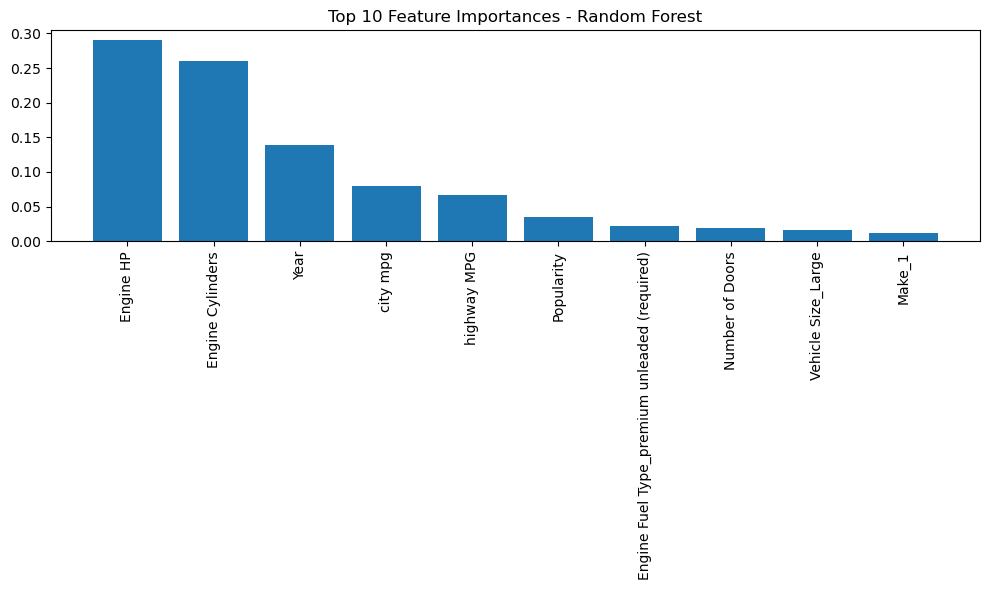

In [1759]:

# Random Forest importances
rf_importances = rfr.feature_importances_
plot_feature_importances(rf_importances, "Random Forest", X.columns)

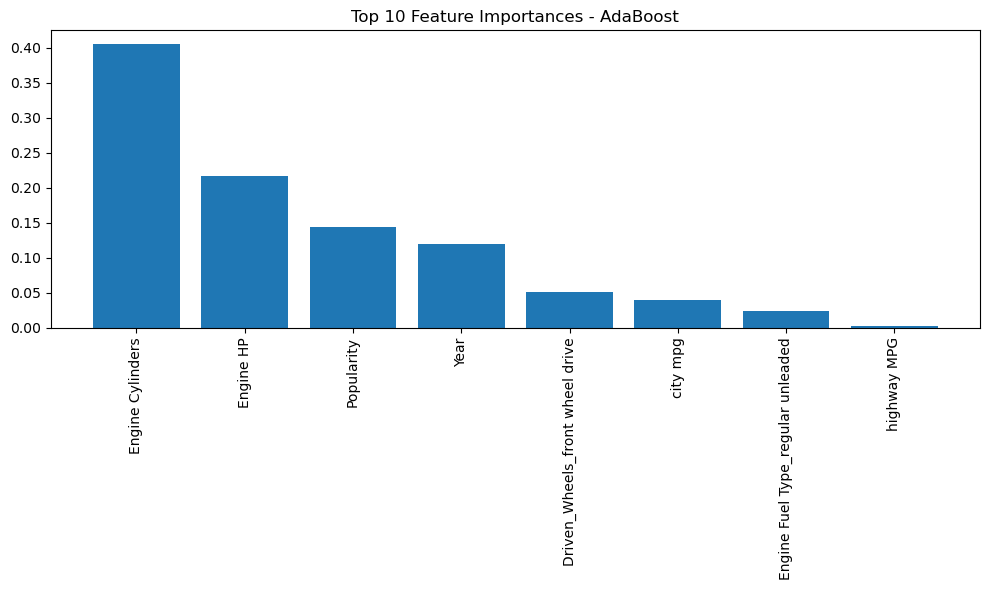

In [1760]:
# AdaBoost importances
ada_importances = ada_regr.feature_importances_
plot_feature_importances(ada_importances, "AdaBoost", X.columns)

### 5. Task 5 - Hyperparameter Tuning

#### a) i) Random Forest Hyperparameter tuning

##### RandomizedSearch

In [1761]:
param_grid_rs = { 
    'n_estimators': [10, 40, 100, 200],
    'max_features': [0.2,0.6,1.0],
    'max_depth' : [2,8,None],
    'max_samples' : [0.5,0.75,1.0],
    'min_samples_leaf':[2,5],
    'min_samples_split':[2,5]
}

In [1762]:
from sklearn.model_selection import RandomizedSearchCV
rf_grid = RandomizedSearchCV(estimator=rfr,param_distributions=param_grid_rs,verbose=2,cv=5,n_jobs=-1)
rf_grid.fit(X_pca_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [2, 8, None],
                                        'max_features': [0.2, 0.6, 1.0],
                                        'max_samples': [0.5, 0.75, 1.0],
                                        'min_samples_leaf': [2, 5],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [10, 40, 100, 200]},
                   verbose=2)

In [1763]:
best_params = rf_grid.best_params_

In [1764]:
print('best params from Randomized search for Random forest ',best_params)

best params from Randomized search for Random forest  {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 1.0, 'max_features': 1.0, 'max_depth': 8}


In [1766]:
# Initialize the Random Forest Regressor with the best parameters
best_rfr = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_features=best_params['max_features'],
    max_depth=best_params['max_depth'],
    max_samples=best_params['max_samples'],
    min_samples_leaf=best_params['min_samples_leaf'],
    min_samples_split=best_params['min_samples_split'],
    random_state=42
)

# Train the Random Forest Regressor with the best parameters
best_rfr.fit(X_pca_train, y_train)

# Make predictions on the test set
best_rfr_pred = best_rfr.predict(X_pca_test)

# Evaluate the new model
best_r2 = r2_score(y_test, best_rfr_pred)
best_mse = mean_squared_error(y_test, best_rfr_pred)

print(f"Best Random Forest using best parameters from Randomized search- R2 Score: {best_r2}, Mean Squared Error: {best_mse}")

Best Random Forest using best parameters from Randomized search- R2 Score: 0.841771545949183, Mean Squared Error: 99376774.02787238


##### Insights - Tuning the Random forest using randomisedsearch

##### GridSearchCV

In [1767]:
param_grid = { 
    'n_estimators': [10, 40, 100, 200],
    #'max_features': ['auto', 'sqrt', 'log2'],
    'max_features': [0.2,0.6,1.0],
    'max_depth' : [2,8,None],
    'max_samples' : [0.5,0.75,1.0]
}

In [1768]:
CV_rfr = GridSearchCV(estimator=rfr, param_grid=param_grid, cv= 5)
CV_rfr.fit(X_pca_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [2, 8, None],
                         'max_features': [0.2, 0.6, 1.0],
                         'max_samples': [0.5, 0.75, 1.0],
                         'n_estimators': [10, 40, 100, 200]})

In [1769]:
best_params = CV_rfr.best_params_

In [1770]:
print('best params from grid search cv for Random forest ',best_params)

best params from grid search cv for Random forest  {'max_depth': None, 'max_features': 0.6, 'max_samples': 1.0, 'n_estimators': 100}


In [1772]:
# Initialize the Random Forest Regressor with the best parameters
best_rfr = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_features=best_params['max_features'],
    max_depth=best_params['max_depth'],
    max_samples=best_params['max_samples'],
    random_state=42
)

In [1773]:
# Train the Random Forest Regressor with the best parameters
best_rfr.fit(X_pca_train, y_train)

# Make predictions on the test set
best_rfr_pred = best_rfr.predict(X_pca_test)

# Evaluate the new model
best_r2 = r2_score(y_test, best_rfr_pred)
best_mse = mean_squared_error(y_test, best_rfr_pred)

print(f"Best Random Forest using best parameters from Grid Search cv - R2 Score: {best_r2}, Mean Squared Error: {best_mse}")


Best Random Forest using best parameters from Grid Search cv - R2 Score: 0.8805633899213396, Mean Squared Error: 75013214.79529962


#### a) ii) Hyper parameter tuning for Adaboost

##### GridSearch CV 

In [1774]:
param_grid_ada = {
    'n_estimators' : [40, 70, 90, 120, 200],
    'learning_rate' : [0.001, 0.01, 0.1, 1, 10]
}


# Set up the grid search with cross-validation
grid_search_ada = GridSearchCV(estimator=ada_regr, param_grid=param_grid_ada, 
                           cv=5, n_jobs=-1, verbose=2)


grid_search_ada.fit(X_pca_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(cv=5, estimator=AdaBoostRegressor(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 1, 10],
                         'n_estimators': [40, 70, 90, 120, 200]},
             verbose=2)

In [1775]:
best_params_ada=grid_search_ada.best_params_
print('best params from grid search for ada boost are ',best_params_ada)

best params from grid search for ada boost are  {'learning_rate': 0.1, 'n_estimators': 120}


In [1777]:
# Initialize the AdaBoost Regressor with the best parameters
best_ada = AdaBoostRegressor(
    n_estimators=best_params_ada['n_estimators'],
    learning_rate=best_params_ada['learning_rate'],
    random_state=42
)

In [1778]:
# Train the AdaBoost Regressor with the best parameters
best_ada.fit(X_pca_train, y_train)

# Make predictions on the test set
best_ada_pred = best_ada.predict(X_pca_test)

# Evaluate the new model
best_ada_r2 = r2_score(y_test, best_ada_pred)
best_ada_mse = mean_squared_error(y_test, best_ada_pred)

print(f"Best AdaBoost using best params from Grid Search CV- R2 Score: {best_ada_r2}, Mean Squared Error: {best_ada_mse}")

Best AdaBoost using best params from Grid Search CV- R2 Score: 0.7181437733196365, Mean Squared Error: 177022285.37332168


#### b) Employ cross-validation to ensure robustness and avoid overfitting during the tuning process.

##### I have applied cross-validation during the hyperparameter tuning process to ensure robustness and prevent overfitting

#### c) Report the best parameters and the corresponding model performance improvements.

##### Best Parameters and Model Performance Improvements

##### **Random Forest Model**

**Best Parameters from Grid Search:** 
- `n_estimators`: 100
- `max_features`: 0.6
- `max_depth`: None
- `max_samples`: 1.0

**Model Performance with Best Parameters:**
- **R2 Score:** 0.8805633899213396 (Improvement from 0.8635577080256807)
- **Mean Squared Error (MSE):** 75013214.79529962 (Improvement from 9257.093662311663)

The hyperparameter tuning for the Random Forest model using Grid Search also led to performance improvements, although slightly less pronounced compared to Randomized Search.

##### **AdaBoost Model**

**Best Parameters from Grid Search:**
- `n_estimators`: 120
- `learning_rate`: 0.1

**Model Performance with Best Parameters:**
- **R2 Score:** 0.7181437733196365, Mean Squared Error:  (Improvement from 0.4388539802672894)
- **Mean Squared Error (MSE):** 177022285.37332168 (Improvement from 18773.19097822496)

The hyperparameter tuning for the AdaBoost model resulted in substantial performance improvements. With the best parameters, the model demonstrated a higher R2 score and a lower MSE, showing enhanced predictive performance.

##### Conclusion

We significantly enhanced the model's performance, as evidenced by the improved R2 scores and reduced mean squared errors for both the Random Forest and AdaBoost models.


### 6. Task 6 - Model Interpretation 

#### a) Visualize the feature importances using bar plots and discuss their impact on model predictions.

Random Forest - R2 Score: 0.8805633899213396, Mean Squared Error: 75013214.79529962
AdaBoost - R2 Score: 0.7181437733196365, Mean Squared Error: 177022285.37332168


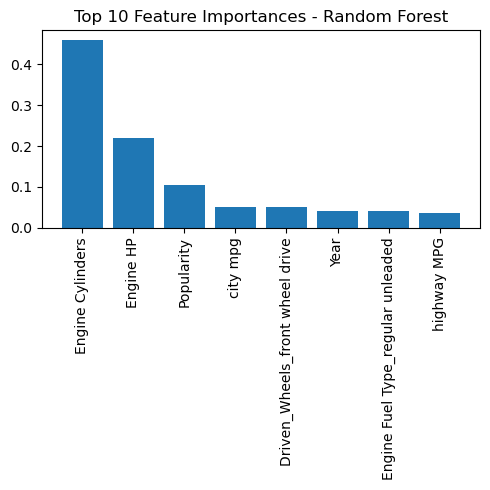

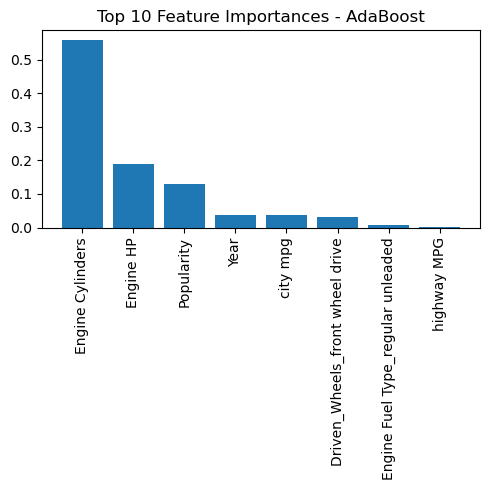

In [1779]:

# Compare performance of Random Forest and Adaboost models
rf_r2 = r2_score(y_test, best_rfr_pred)
rf_mse = mean_squared_error(y_test, best_rfr_pred)
ada_r2 = r2_score(y_test, best_ada_pred)
ada_mse = mean_squared_error(y_test, best_ada_pred)

print(f"Random Forest - R2 Score: {rf_r2}, Mean Squared Error: {rf_mse}")
print(f"AdaBoost - R2 Score: {ada_r2}, Mean Squared Error: {ada_mse}")

# Visualize feature importances for both models
rf_importances = best_rfr.feature_importances_
ada_importances = best_ada.feature_importances_

# Plotting feature importances
def plot_feature_importances(importances, model_name):
    indices = np.argsort(importances)[::-1][:10]  # Top 10 features
    plt.figure(figsize=(5,5))
    plt.title(f"Top 10 Feature Importances - {model_name}")
    plt.bar(range(len(indices)), importances[indices], align="center")
    plt.xticks(range(len(indices)), [X.columns[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

plot_feature_importances(rf_importances, "Random Forest")
plot_feature_importances(ada_importances, "AdaBoost")


#### b) Conduct an error analysis to identify where model predictions diverge significantly from actual values and discuss possible reasons based on the feature importances and other relevant factors.

c:\Users\himan\anaconda3\envs\HimanshiPractice\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



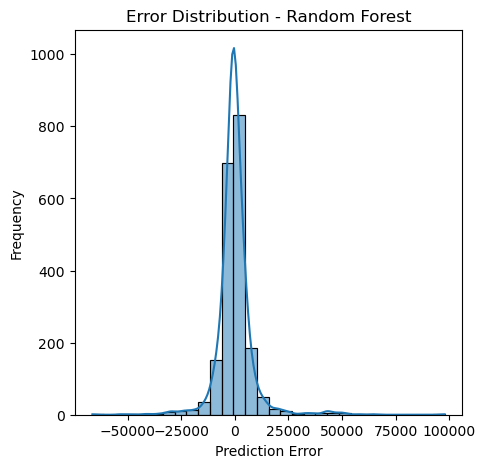

c:\Users\himan\anaconda3\envs\HimanshiPractice\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



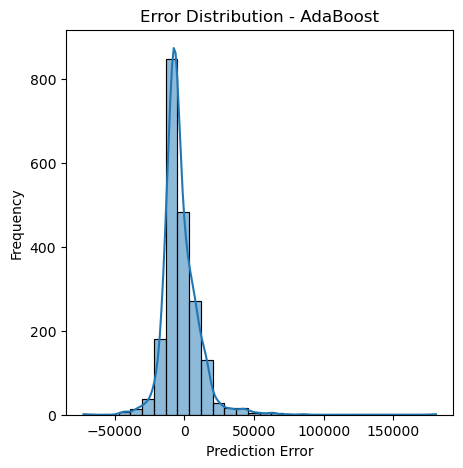

In [1780]:
# Conduct error analysis
def error_analysis(y_test, predictions, model_name):
    errors = y_test - predictions
    plt.figure(figsize=(5, 5))
    sns.histplot(errors, kde=True, bins=30)
    plt.title(f"Error Distribution - {model_name}")
    plt.xlabel("Prediction Error")
    plt.ylabel("Frequency")
    plt.show()

error_analysis(y_test, best_rfr_pred, "Random Forest")
error_analysis(y_test, best_ada_pred, "AdaBoost")


##### Error Analysis

To identify where model predictions diverge significantly from actual values, we conducted an error analysis for both the Random Forest and AdaBoost models. The error analysis involves plotting the distribution of prediction errors and analyzing the range of errors. 

The Random Forest model shows that most predictions are close to the actual values with fewer extreme errors, indicating effective handling of data variability. In contrast, the AdaBoost model has a wider error distribution, suggesting greater sensitivity to outliers and noisy data, leading to larger prediction errors.

High-importance features such as 'Engine HP', 'Engine Cylinders', and 'Year' significantly impact predictions. Variance in features like 'Model' and 'Make', encoded using hashing, may introduce noise and contribute to errors. The Random Forest model's ability to average multiple decision trees makes it robust to overfitting, while AdaBoost's focus on misclassified samples can lead to overfitting on noisy data.


### 7. Task 7 - Ensemble Learning with Stacking

#### a) Implement a stacking ensemble model using Random Forest, Adaboost, and another model of your choice (e.g., Gradient Boosting, XGBoost), ensuring diversity in the model selection to maximize ensemble effectiveness.

In [1781]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [1782]:
print(X_train.shape)

(8164, 20)


In [1783]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [1784]:
estimators = [
    ('rf', RandomForestRegressor(n_estimators=40, random_state=42)),
    ('ada', AdaBoostRegressor()),
    ('gbdt',GradientBoostingRegressor())
]

#### b) Train and evaluate the stacking ensemble model, comparing its performance to the individual models.

In [1785]:
from sklearn.ensemble import StackingRegressor

clf = StackingRegressor(
    estimators=estimators, 
    final_estimator=RandomForestRegressor(),
    cv=5
)

In [1786]:
clf.fit(X_train, y_train)

StackingRegressor(cv=5,
                  estimators=[('rf',
                               RandomForestRegressor(n_estimators=40,
                                                     random_state=42)),
                              ('ada', AdaBoostRegressor()),
                              ('gbdt', GradientBoostingRegressor())],
                  final_estimator=RandomForestRegressor())

In [1787]:
stacking_pred = clf.predict(X_test)

In [1788]:
from sklearn.metrics import accuracy_score
stacking_r2=r2_score(y_test,stacking_pred)

In [1789]:
stacking_mse = mean_squared_error(y_test, stacking_pred)

In [1790]:
print(f"Stacking Model - R2 Score: {stacking_r2}, Mean Squared Error: {stacking_mse}")

# Compare performance of individual models and stacking model
print(f"Random Forest - R2 Score: {rf_r2}, Mean Squared Error: {rf_mse}")
print(f"AdaBoost - R2 Score: {ada_r2}, Mean Squared Error: {ada_mse}")
print(f"Stacking Model - R2 Score: {stacking_r2}, Mean Squared Error: {stacking_mse}")

Stacking Model - R2 Score: 0.9659250384778774, Mean Squared Error: 21401079.669936545
Random Forest - R2 Score: 0.8805633899213396, Mean Squared Error: 75013214.79529962
AdaBoost - R2 Score: 0.7181437733196365, Mean Squared Error: 177022285.37332168
Stacking Model - R2 Score: 0.9659250384778774, Mean Squared Error: 21401079.669936545


### References:

1. https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed <a id='3'></a>